# The 1D Ising model

As an example for a magnetic material we will simulate a 1D chain of spins, the **1D Ising model**. We will use a Markov Chain Monte Carlo approach with Metropolis sampling to simulate configurations of the chain at a temperature $T$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.matplotlib.style.use('ggplot')

import tqdm

rng = np.random.default_rng(seed=20220428)

In [2]:
# loosely based on Computational Modelling Ch 11 (program 11.6)


class SpinChain:
    def __init__(self, N, kT=1.0, p=0.5):
        """Set up 1D chain with N spins, fraction p flipped down"""
        self.N = N
        self.kT = kT
        self.beta = 1/self.kT
        # initialize by flipping a spin to down with probability p
        self.spins = np.where(rng.uniform(size=N) <= p, -1, 1)
        self.E = None
        self.M = None
        
    def energy(self):
        """total energy in units of epsilon"""
        s = self.spins
        E = np.sum(-s[:-1] * s[1:])   # nearest neighbors
        E += - s[-1] * s[0]    # periodic boundary conditions
        return float(E)
    
    def magnetization(self):
        return float(np.sum(self.spins))
    
    def update(self, i):
        """Update of a single spin i with Metropolis criterion"""
        # i = rng.integers(low=0, high=N, dtype=int)

        s = self.spins
        
        accept = False
        dE = 2 * s[i] * (s[i-1] + s[(i+1) % self.N])  # with periodic boundary conditions
        if dE <= 0:
            accept = True
        else:
            p = np.exp(-self.beta * dE)
            accept = (rng.uniform() < p)
            
        if accept:
            s[i] *= -1
        
        return accept

    def _update(self, i, randfloat):
        """Update of a single spin i with Metropolis criterion.
        
        Generate a random float 0 <= x < 1 for Metropolis in advance.
        """
        
        s = self.spins
        
        accept = False
        dE = 2 * s[i] * (s[i-1] + s[(i+1) % self.N])  # with periodic boundary conditions
        if dE <= 0:
            accept = True
        else:
            p = np.exp(-self.beta * dE)
            accept = (randfloat < p)
            
        if accept:
            s[i] *= -1
        
        return accept
    
    def run(self, iterations=1000, verbose=True):
        """Run `iterations` sweeps of updates."""
        energies = []
        magnetizations = []
        n_accept = 0
        for iteration in tqdm.tqdm(range(iterations), disable=not verbose):
            for i, x in zip(rng.integers(low=0, high=self.N, dtype=int, size=self.N),
                            rng.uniform(size=self.N)):
                accept = self._update(i, x)
                n_accept += accept
            energies.append(self.energy())
            magnetizations.append(self.magnetization())
            
        acceptance_ratio = n_accept / (self.N * iterations)
        self.E = np.array(energies)
        self.M = np.array(magnetizations)
        
        return self.E, self.M, acceptance_ratio
    
    def average(self, a, burnin):
        start = int(round(burnin * len(a)))
        return np.average(a[start:])
    
    def E_average(self, burnin=0.1):
        """<E>/N (with initial burnin % removed)"""
        return self.average(self.E, burnin)/self.N
    
    def M_average(self, burnin=0.1):
        """<M>/N (with initial burnin % removed)"""
        return self.average(self.M, burnin)/self.N

def E_analytical(T):
    return -np.tanh(1/T)

In [3]:
model = SpinChain(100, kT=1,  p=0.5)

E, M, r = model.run(iterations=10000)
print(r)

100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1681.73it/s]

0.238394


-0.76292


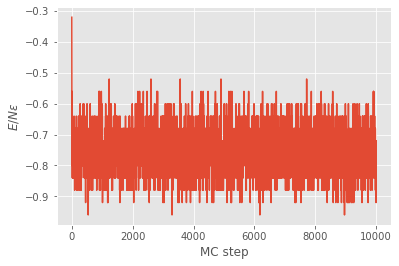

In [8]:
print(model.E_average())
plt.plot(E/model.N)
plt.xlabel(r"MC step")
plt.ylabel(r"$E/N\epsilon$");

0.01428888888888889


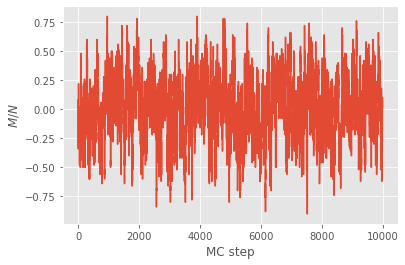

In [9]:
print(model.M_average())
plt.plot(M/model.N)
plt.xlabel(r"MC step")
plt.ylabel(r"$M/N$");

## Temperature dependence of E and M

The dependence of the average energy per spin $\langle E \rangle/N$ on the temperature $T$ for the 1D spin chain is

$$
\frac{\langle E \rangle}{N} = -\epsilon \tanh\frac{\epsilon}{kT}.
$$

The average magnetization per spin $\langle M \rangle/N = 0$ is zero for the 1D chain for all temperatures.


Run the simulation for a range of temperatures (measured in $kT$):

In [11]:
temperatures = np.linspace(0.1, 10, 100)

Nspins = 100
energy = np.zeros_like(temperatures)
magnetization = np.zeros_like(temperatures)

for j, kT in tqdm.tqdm(enumerate(temperatures), total=len(temperatures)):
    model = SpinChain(Nspins, kT=kT)
    model.run(iterations=1000, verbose=False)
    energy[j] = model.E_average()
    magnetization[j] = model.M_average()


100%|█████████████████████████████████████████| 100/100 [00:40<00:00,  2.44it/s]


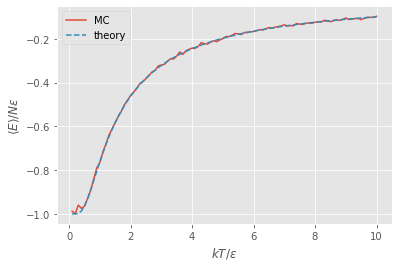

In [12]:
plt.plot(temperatures, energy, label="MC")
plt.plot(temperatures, E_analytical(temperatures), '--', label="theory")
plt.xlabel(r"$kT/\epsilon$")
plt.ylabel(r"$\langle E\rangle/N\epsilon$")
plt.legend();

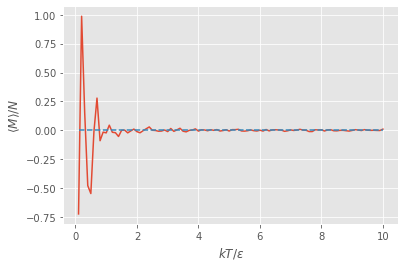

In [13]:
plt.plot(temperatures, magnetization, label="MC")
plt.plot(temperatures, np.zeros_like(temperatures), "--", label="theory")
plt.xlabel(r"$kT/\epsilon$")
plt.ylabel(r"$\langle M \rangle/N$");